# Spatial Weights


Spatial weights are mathematical structures used to represent spatial relationships. Many spatial analytics, such as spatial autocorrelation statistics and regionalization algorithms rely on spatial weights. Generally speaking, a spatial weight $w_{i,j}$ expresses the notion of a geographical relationship between locations $i$ and $j$. These relationships can be based on a number of criteria including contiguity, geospatial distance and general distances.

libpysal offers functionality for the construction, manipulation, analysis, and conversion of a wide array of spatial weights.

We begin with construction of weights from common spatial data formats.


In [1]:
import libpysal 
from libpysal.weights import Queen, Rook, KNN, Kernel, DistanceBand
import numpy as np
import geopandas
import pandas
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from splot.libpysal import plot_spatial_weights

There are functions to construct weights directly from a file path. 

## Weight Types

### Contiguity

#### Queen Weights

A commonly-used type of weight is a queen contigutiy weight, which reflects adjacency relationships as a binary indicator variable denoting whether or not a polygon shares an edge or a vertex with another polygon. These weights are symmetric, in that when polygon $A$ neighbors polygon $B$, both $w_{AB} = 1$ and $w_{BA} = 1$.

To construct queen weights from a shapefile, we will use geopandas to read the file into a GeoDataFrame, and then use   libpysal to construct the weights:

In [3]:
path = "data/scag_region.gpkg"
df = geopandas.read_file(path)
df.head()

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,...,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry
0,06037128702,58.0,0.0,223.0,0.0,475.0,986.0,None,None,None,...,2010,2903.0,64.726214,None,None,None,None,None,None,"POLYGON ((-118.44870 34.16485, -118.43997 34.1..."
1,06037131600,83.0,62.0,777.0,0.0,135.0,1355.0,None,None,None,...,2010,1487.0,28.679979,None,None,None,None,None,None,"POLYGON ((-118.56229 34.22033, -118.55792 34.2..."
2,06037134104,287.0,17.0,816.0,0.0,61.0,1323.0,None,None,None,...,2010,1388.0,14.846188,None,None,None,None,None,None,"POLYGON ((-118.57976 34.21558, -118.57539 34.2..."
3,06037134304,90.0,24.0,298.0,0.0,89.0,520.0,None,None,None,...,2010,928.0,33.378933,None,None,None,None,None,None,"POLYGON ((-118.61472 34.21952, -118.61039 34.2..."
4,06037242000,0.0,229.0,681.0,0.0,0.0,1164.0,None,None,None,...,2010,1054.0,0.058565,None,None,None,None,None,None,"POLYGON ((-118.25416 33.93882, -118.25413 33.9..."


In [4]:
df = df.to_crs(26911)  #UTM zone 11N

In [5]:
qW = Queen.from_dataframe(df)

/Users/knaaptime/anaconda3/envs/pysal-workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 4285.
  warnings.warn(message)


In [6]:
qW

All weights objects have a few traits that you can use to work with the weights object, as well as to get information about the weights object. 

To get the neighbors & weights around an observation, use the observation's index on the weights object, like a dictionary:

In [7]:
qW[155] #neighbors & weights of the 156th observation (0-index remember)

{4528: 1.0, 547: 1.0, 2133: 1.0, 2744: 1.0}

By default, the weights and the pandas dataframe will use the same index. So, we can view the observation and its neighbors in the dataframe by putting the observation's index and its neighbors' indexes together in one list:

In [8]:
self_and_neighbors = [155]
self_and_neighbors.extend(qW.neighbors[155])
print(self_and_neighbors)

[155, 4528, 547, 2133, 2744]


and grabbing those elements from the dataframe:

In [9]:
df.loc[self_and_neighbors]

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,...,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry
155,06037552302,26.0,80.0,630.0,0.0,0.0,913.0,None,None,None,...,2010,1268.0,22.060410,None,None,None,None,None,None,"POLYGON ((401577.992 3752226.404, 401578.584 3..."
4528,06037552400,0.0,20.0,670.0,0.0,24.0,821.0,None,None,None,...,2010,588.0,5.576363,None,None,None,None,None,None,"POLYGON ((401879.006 3751827.388, 402203.644 3..."
547,06037552301,59.0,103.0,1079.0,5.0,0.0,1777.0,None,None,None,...,2010,1272.0,8.472352,None,None,None,None,None,None,"POLYGON ((400855.773 3753114.885, 400857.902 3..."
2133,06037552200,38.0,141.0,1484.0,0.0,52.0,2235.0,None,None,None,...,2010,1902.0,6.858581,None,None,None,None,None,None,"POLYGON ((399998.906 3752819.359, 400004.865 3..."
2744,06037504102,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,...,2010,0.0,NaN,None,None,None,None,None,None,"POLYGON ((401631.581 3751829.617, 401879.006 3..."


A full, dense matrix describing all of the pairwise relationships is constructed using the `.full` method, or when `libpysal.weights.full` is called on a weights object:

In [10]:
Wmatrix, ids = qW.full()
#Wmatrix, ids = libpysal.weights.full(qW)

In [11]:
Wmatrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
n_neighbors = Wmatrix.sum(axis=1) # how many neighbors each region has

In [13]:
n_neighbors[155]

4.0

In [14]:
qW.cardinalities[155]

4

Note that this matrix is binary, in that its elements are either zero or one, since an observation is either a neighbor or it is not a neighbor. 

However, many common use cases of spatial weights require that the matrix is row-standardized. This is done simply in PySAL using the `.transform` attribute

In [15]:
qW.transform = 'r'

('WARNING: ', 4285, ' is an island (no neighbors)')


Now, if we build a new full matrix, its rows should sum to one:

In [16]:
Wmatrix, ids = qW.full()

In [17]:
Wmatrix.sum(axis=1) #numpy axes are 0:column, 1:row, 2:facet, into higher dimensions

array([1., 1., 1., ..., 1., 1., 1.])

Since weight matrices are typically very sparse, there is also a sparse weights matrix constructor:

In [18]:
qW.sparse

<4580x4580 sparse matrix of type '<class 'numpy.float64'>'
	with 29374 stored elements in Compressed Sparse Row format>

In [19]:
qW.pct_nonzero #Percentage of nonzero neighbor counts

0.14003356152628668

Let's look at the neighborhoods of the 101th observation

In [20]:
df.iloc[100]

geoid                                                        06037910606
n_asian_under_15                                                       0
n_black_under_15                                                     210
n_hispanic_under_15                                                  757
n_native_under_15                                                      3
                                             ...                        
p_hispanic_over_60                                                  None
p_native_over_60                                                    None
p_asian_over_60                                                     None
p_disabled                                                          None
geometry               POLYGON ((401275.3267007071 3825401.441630058,...
Name: 100, Length: 194, dtype: object

In [21]:
qW.neighbors[100]

[789, 790, 1991, 3676, 791]

In [22]:
len(qW.neighbors[100])

5

In [23]:
df.iloc[qW.neighbors[100]]

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,...,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry
789,06037910605,14.0,161.0,860.0,0.0,115.0,1571.0,None,None,None,...,2010,1295.0,19.775281,None,None,None,None,None,None,"POLYGON ((401288.939 3826196.618, 402103.794 3..."
790,06037910712,3.0,16.0,375.0,0.0,50.0,665.0,None,None,None,...,2010,724.0,18.216033,None,None,None,None,None,None,"POLYGON ((402885.247 3824547.186, 402894.329 3..."
1991,06037910603,72.0,162.0,1465.0,0.0,321.0,2371.0,None,None,None,...,2010,2001.0,21.765830,None,None,None,None,None,None,"POLYGON ((399656.136 3826203.296, 400480.176 3..."
3676,06037910711,50.0,440.0,1567.0,27.0,162.0,2650.0,None,None,None,...,2010,2351.0,19.146422,None,None,None,None,None,None,"POLYGON ((402109.033 3827007.302, 402932.105 3..."
791,06037910715,67.0,352.0,1261.0,36.0,219.0,2282.0,None,None,None,...,2010,1934.0,17.863582,None,None,None,None,None,None,"POLYGON ((400453.269 3824402.083, 400474.093 3..."


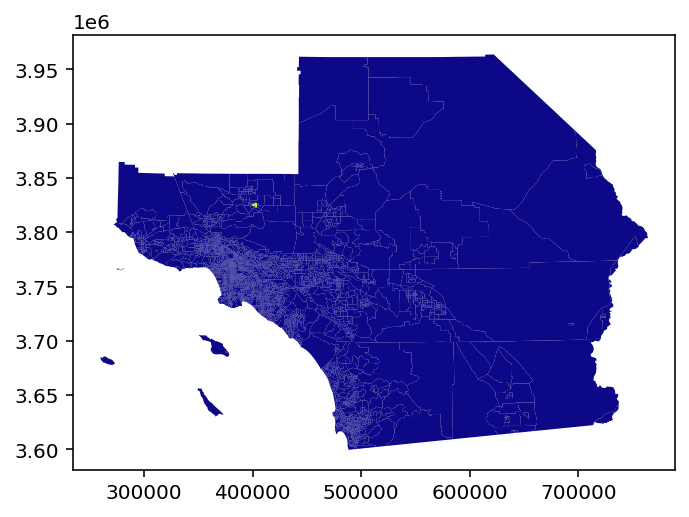

In [24]:
df.assign(weights = qW.sparse[100,:].toarray().flatten()).plot('weights', cmap='plasma')           

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9a63af2bd0>)

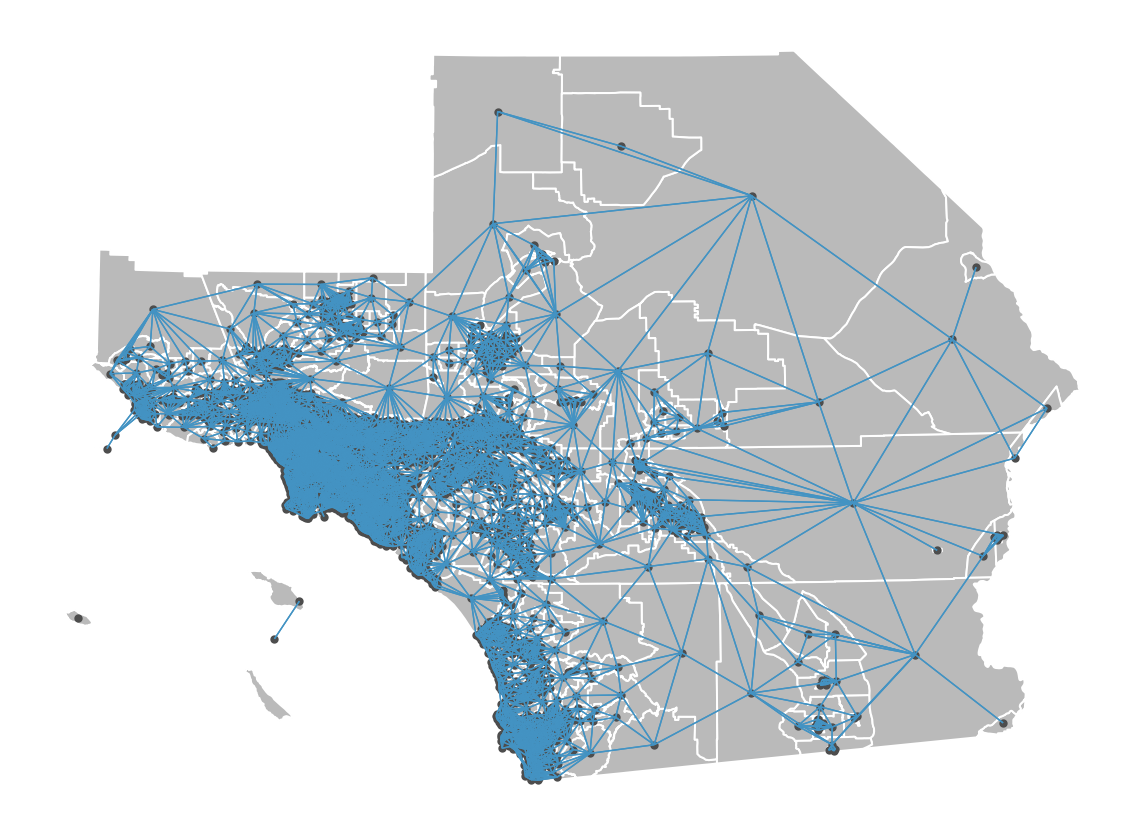

In [25]:
plot_spatial_weights(qW, df)

By default, PySAL assigns each observation an index according to the order in which the observation was read in. This means that, by default, all of the observations in the weights object are indexed by table order.

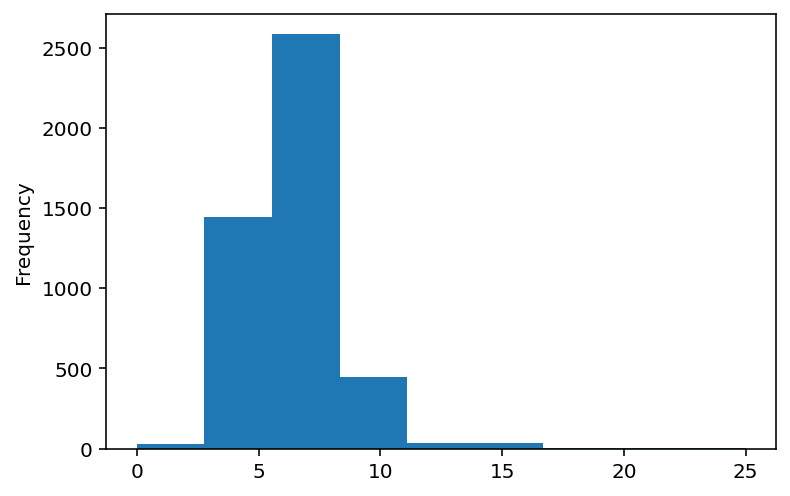

In [26]:
pandas.Series(qW.cardinalities).plot.hist(bins=9)

In [27]:
qW.cardinalities.values()

dict_values([9, 9, 4, 7, 7, 5, 5, 6, 5, 8, 9, 8, 4, 3, 5, 5, 6, 6, 4, 5, 5, 6, 7, 9, 6, 4, 7, 8, 7, 5, 7, 2, 6, 6, 8, 3, 7, 7, 5, 8, 6, 5, 5, 4, 6, 6, 7, 7, 4, 6, 7, 4, 5, 6, 13, 6, 7, 6, 8, 6, 6, 6, 2, 6, 6, 8, 6, 7, 7, 6, 3, 5, 6, 6, 3, 7, 6, 5, 5, 5, 8, 8, 6, 8, 9, 7, 7, 6, 7, 5, 5, 7, 7, 6, 5, 7, 8, 8, 4, 7, 5, 4, 4, 6, 9, 6, 6, 7, 4, 8, 6, 6, 5, 6, 6, 6, 6, 7, 6, 8, 6, 6, 6, 8, 6, 6, 5, 8, 4, 5, 7, 5, 5, 5, 5, 5, 2, 4, 4, 7, 6, 8, 6, 9, 4, 6, 7, 5, 5, 6, 6, 4, 8, 9, 7, 4, 8, 4, 6, 5, 5, 4, 5, 6, 7, 8, 4, 6, 5, 6, 6, 6, 4, 6, 7, 6, 5, 6, 7, 6, 7, 7, 7, 7, 3, 10, 6, 6, 7, 7, 5, 6, 7, 8, 6, 5, 9, 7, 9, 6, 6, 4, 6, 6, 5, 7, 7, 7, 6, 4, 7, 8, 7, 5, 6, 6, 4, 6, 6, 5, 9, 7, 5, 7, 4, 7, 7, 3, 6, 7, 5, 5, 6, 6, 5, 4, 6, 5, 5, 6, 5, 10, 4, 3, 6, 1, 8, 6, 4, 5, 5, 7, 6, 4, 7, 4, 5, 6, 6, 5, 10, 3, 5, 5, 9, 5, 7, 5, 5, 7, 5, 8, 4, 6, 5, 7, 7, 7, 5, 6, 7, 5, 3, 7, 5, 4, 6, 3, 5, 6, 5, 5, 5, 4, 4, 7, 7, 5, 5, 5, 7, 9, 6, 4, 4, 5, 7, 4, 4, 7, 4, 6, 6, 4, 8, 6, 7, 5, 8, 6, 7, 6, 8, 8, 4, 5, 7, 6,

#### Rook Weights

Rook weights are another type of contiguity weight, but consider observations as neighboring only when they share an edge. The rook neighbors of an observation may be different than its queen neighbors, depending on how the observation and its nearby polygons are configured. 

We can construct this in the same way as the queen weights:

In [28]:
rW = Rook.from_dataframe(df)

/Users/knaaptime/anaconda3/envs/pysal-workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 4285.
  warnings.warn(message)


In [29]:
rW.neighbors[100]

[789, 790, 1991, 791, 3676]

In [30]:
len(rW.neighbors[100])

5

In [31]:
df.iloc[rW.neighbors[100]]

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,...,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry
789,06037910605,14.0,161.0,860.0,0.0,115.0,1571.0,None,None,None,...,2010,1295.0,19.775281,None,None,None,None,None,None,"POLYGON ((401288.939 3826196.618, 402103.794 3..."
790,06037910712,3.0,16.0,375.0,0.0,50.0,665.0,None,None,None,...,2010,724.0,18.216033,None,None,None,None,None,None,"POLYGON ((402885.247 3824547.186, 402894.329 3..."
1991,06037910603,72.0,162.0,1465.0,0.0,321.0,2371.0,None,None,None,...,2010,2001.0,21.765830,None,None,None,None,None,None,"POLYGON ((399656.136 3826203.296, 400480.176 3..."
791,06037910715,67.0,352.0,1261.0,36.0,219.0,2282.0,None,None,None,...,2010,1934.0,17.863582,None,None,None,None,None,None,"POLYGON ((400453.269 3824402.083, 400474.093 3..."
3676,06037910711,50.0,440.0,1567.0,27.0,162.0,2650.0,None,None,None,...,2010,2351.0,19.146422,None,None,None,None,None,None,"POLYGON ((402109.033 3827007.302, 402932.105 3..."


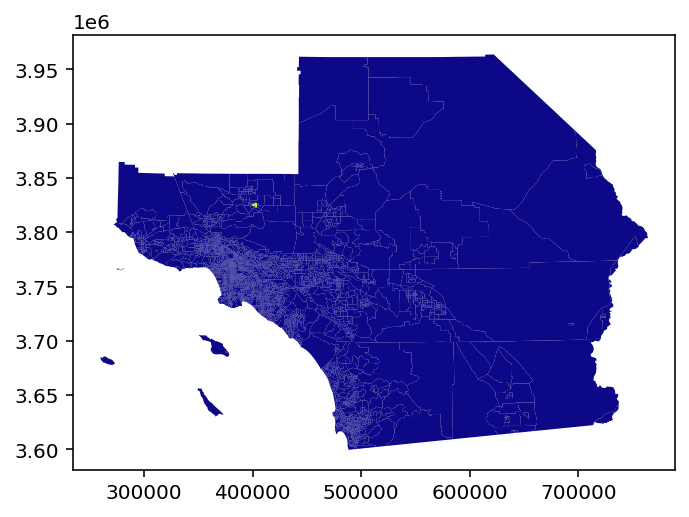

In [32]:
df.assign(weights = rW.sparse[100,:].toarray().flatten()).plot('weights', cmap='plasma')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9a64f3ef90>)

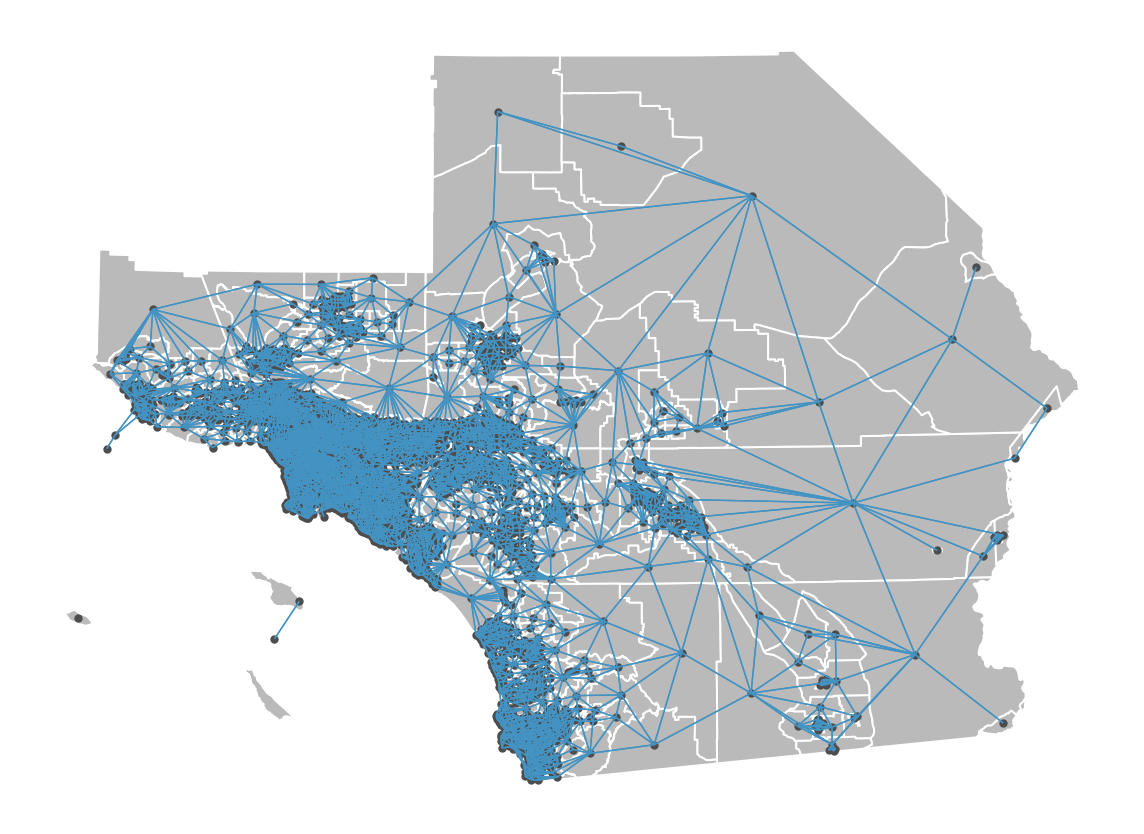

In [33]:
plot_spatial_weights(rW, df)

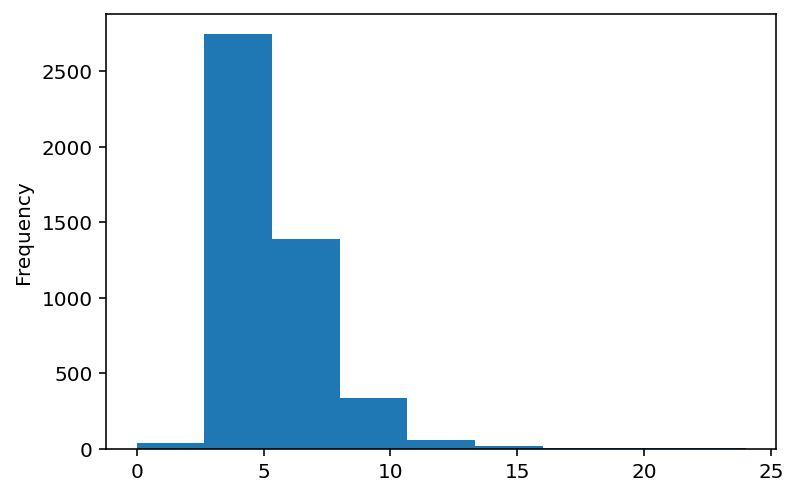

In [34]:
pandas.Series(rW.cardinalities).plot.hist(bins=9)

#### Bishop Weights

In theory, a "Bishop" weighting scheme is one that arises when only polygons that share vertexes are considered to be neighboring. But, since Queen contiguigy requires either an edge or a vertex and Rook contiguity requires only shared edges, the following relationship is true:

$$ \mathcal{Q} = \mathcal{R} \cup \mathcal{B} $$

where $\mathcal{Q}$ is the set of neighbor pairs *via* queen contiguity, $\mathcal{R}$ is the set of neighbor pairs *via* Rook contiguity, and $\mathcal{B}$ *via* Bishop contiguity. Thus:

$$ \mathcal{Q} \setminus \mathcal{R} = \mathcal{B}$$

Bishop weights entail all Queen neighbor pairs that are not also Rook neighbors.

PySAL does not have a dedicated bishop weights constructor, but you can construct very easily using the `w_difference` function. This function is one of a family of tools to work with weights, all defined in `libpysal.weights`, that conduct these types of set operations between weight objects.

In [35]:
bW = libpysal.weights.w_difference(qW, rW, constrained=False)

/Users/knaaptime/anaconda3/envs/pysal-workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2333 disconnected components.
 There are 1624 islands with ids: 2, 5, 7, 8, 12, 13, 16, 21, 24, 25, 29, 31, 35, 39, 40, 41, 42, 43, 44, 48, 51, 56, 62, 70, 71, 73, 74, 89, 90, 94, 98, 100, 101, 102, 103, 108, 110, 112, 115, 122, 128, 129, 131, 135, 136, 138, 140, 144, 147, 151, 155, 157, 161, 162, 164, 172, 184, 200, 202, 203, 204, 209, 214, 216, 219, 222, 224, 226, 227, 230, 235, 237, 242, 243, 244, 245, 247, 248, 250, 253, 254, 255, 256, 258, 261, 262, 270, 272, 282, 284, 287, 288, 291, 293, 294, 297, 298, 299, 300, 305, 307, 308, 310, 313, 315, 325, 328, 329, 333, 335, 337, 338, 340, 344, 345, 346, 350, 351, 353, 355, 359, 360, 362, 363, 369, 371, 372, 378, 381, 383, 390, 392, 393, 396, 400, 402, 403, 405, 408, 410, 413, 415, 418, 420, 421, 424, 428, 430, 431, 438, 443, 444, 446, 450, 456, 458, 460, 473, 474, 

In [36]:
bW = libpysal.weights.w_difference(qW, rW, constrained=False)

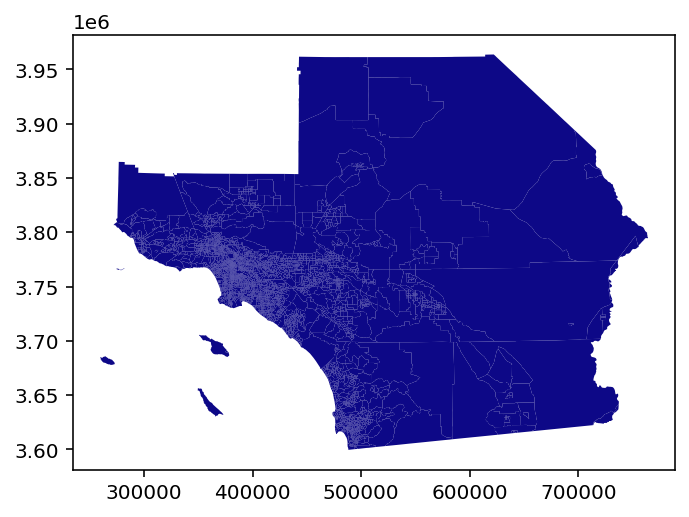

In [37]:
df.assign(weights = bW.sparse[100,:].toarray().flatten()).plot('weights', cmap='plasma')

In [38]:
bW.histogram

[(0, 1624), (1, 1728), (2, 881), (3, 292), (4, 55)]

Thus, many tracts have no bishop neighbors. But, a few do. A simple way to see these observations in the dataframe is to find all elements of the dataframe that are not "islands," the term for an observation with no neighbors:

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9a650e6fd0>)

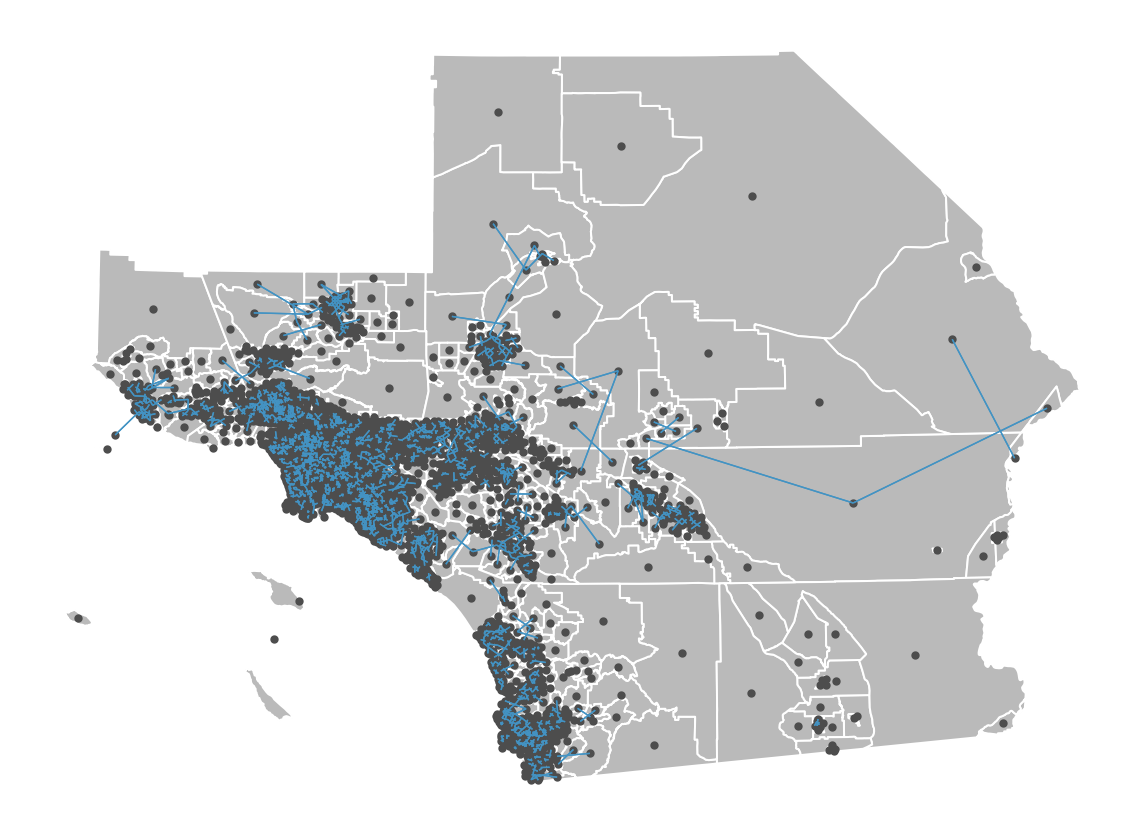

In [39]:
plot_spatial_weights(bW, df)

## Distance

There are many other kinds of weighting functions in PySAL. Another separate type use a continuous measure of distance to define neighborhoods. 

In [40]:
df.crs

<Projected CRS: EPSG:26911>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 120°W to 114°W and NAD83 by country
- bounds: (-120.0, 30.88, -114.0, 83.5)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Our coordinate system (UTM 11N) measures distance in meters, so that's how we'll define our neighbors

In [41]:
dist_band = DistanceBand.from_dataframe(df, threshold=2000)

/Users/knaaptime/anaconda3/envs/pysal-workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 626 disconnected components.
 There are 528 islands with ids: 157, 159, 161, 162, 163, 164, 165, 171, 209, 236, 240, 241, 243, 245, 276, 289, 344, 393, 405, 406, 415, 437, 444, 447, 453, 457, 459, 461, 481, 482, 484, 489, 490, 491, 492, 500, 518, 539, 679, 774, 796, 873, 877, 907, 908, 923, 947, 963, 970, 971, 972, 973, 1017, 1053, 1055, 1066, 1070, 1082, 1105, 1118, 1141, 1158, 1167, 1168, 1209, 1211, 1212, 1221, 1222, 1230, 1295, 1374, 1390, 1394, 1412, 1413, 1424, 1426, 1427, 1433, 1435, 1444, 1477, 1486, 1492, 1512, 1543, 1544, 1559, 1565, 1571, 1572, 1574, 1575, 1583, 1584, 1592, 1603, 1605, 1606, 1611, 1612, 1613, 1621, 1628, 1636, 1637, 1639, 1640, 1642, 1656, 1660, 1661, 1663, 1669, 1670, 1679, 1694, 1696, 1697, 1698, 1699, 1702, 1719, 1720, 1727, 1729, 1737, 1738, 1741, 1743, 1744, 1746, 1757, 1758, 1762

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9a665d4150>)

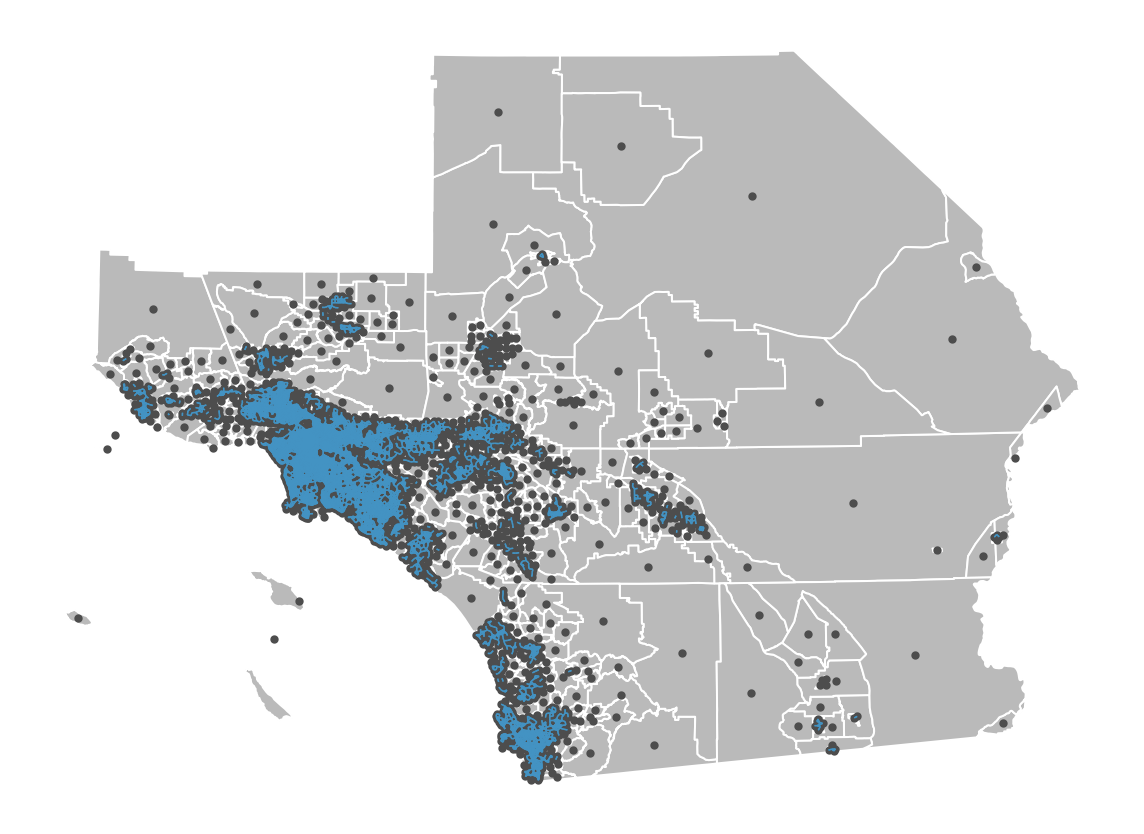

In [42]:
plot_spatial_weights(dist_band,df)

### knn defined weights

In [43]:
radius_mile = libpysal.cg.sphere.RADIUS_EARTH_MILES
radius_mile

3958.755865744055

In [44]:
df_latlong = df.to_crs(4326)

In [45]:
knn8_bad = KNN.from_dataframe(df_latlong, k=8) # ignore curvature of the earth

In [46]:
knn8_bad.histogram

[(8, 4580)]

In [47]:
knn8 = KNN.from_dataframe(df_latlong, k=8, radius=radius_mile)

In [48]:
knn8.histogram

[(8, 4580)]

In [49]:
knn8_bad.neighbors[1487]

[501, 2296, 2960, 974, 167, 4496, 2295, 4422]

In [50]:
knn8.neighbors[1487]

[501, 2960, 2296, 974, 167, 4496, 2881, 2297]

<div class="alert alert-success" style="font-size:120%">
<b>Exercise</b>: <br>
Enumerate the counties for which ignoring curvature results in an incorrect neighbor set for knn.
</div>

In [51]:
# %load solution

### Kernel W

Kernel Weights are continuous distance-based weights that use kernel densities to define the neighbor relationship.
Typically, they estimate a `bandwidth`, which is a parameter governing how far out observations should be considered neighboring. Then, using this bandwidth, they evaluate a continuous kernel function to provide a weight between 0 and 1.

Many different choices of kernel functions are supported, and bandwidths can either be fixed (constant over all units) or adaptive in function of unit density.

For example, if we want to use **adaptive bandwidths for the map and weight according to a gaussian kernel**:

#### Adaptive gaussian kernel weights

bandwidth = the distance to the kth nearest neighbor for each
                  observation
   
bandwith is changing across observations

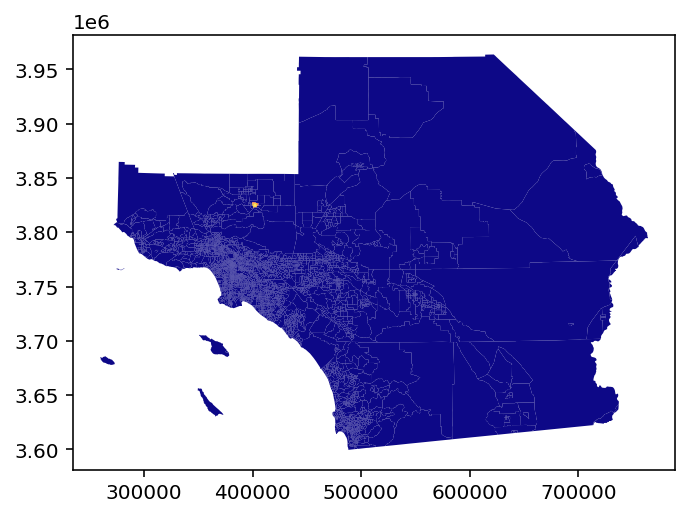

In [52]:
kernelWa = Kernel.from_dataframe(df, k=10, fixed=False, function='gaussian')
df.assign(weights = 
          kernelWa.sparse[100,:].toarray().flatten()).plot('weights', 
                                                           cmap='plasma')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9a4aa0a950>)

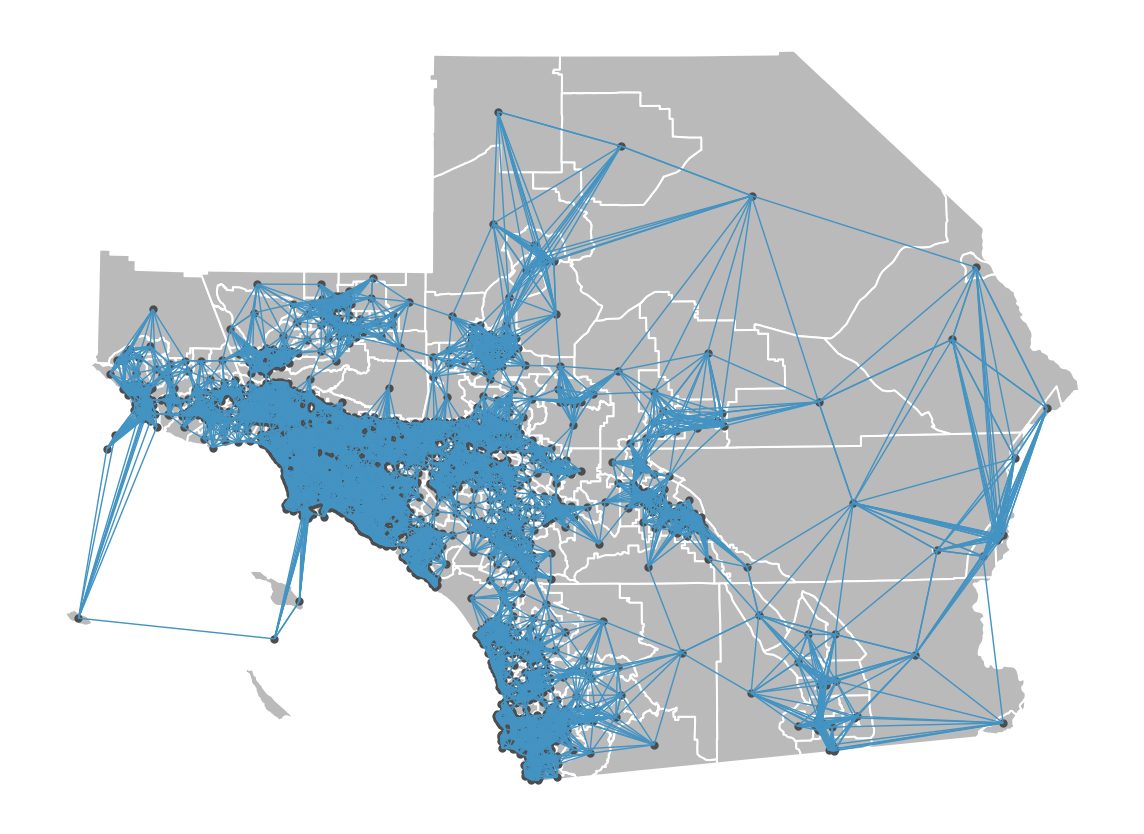

In [53]:
plot_spatial_weights(kernelWa, df)

In [54]:
kernelWa.bandwidth

array([[1687.98315102],
       [1997.79763417],
       [1803.36975814],
       ...,
       [2468.39053934],
       [3480.80242265],
       [1749.83295263]])

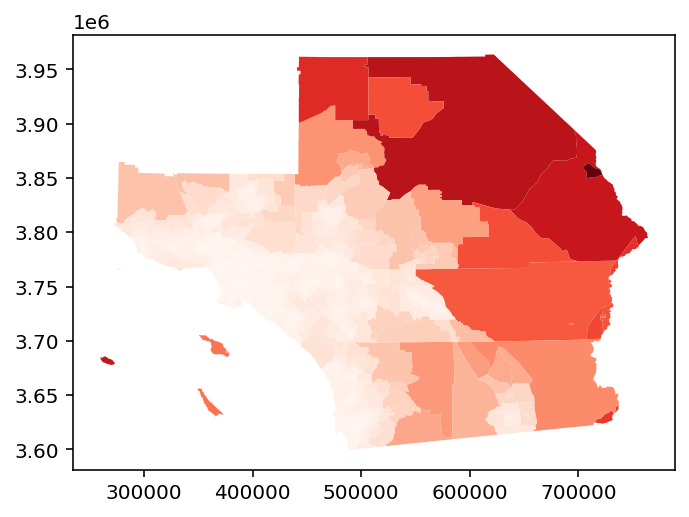

In [55]:
df.assign(bw=kernelWa.bandwidth.flatten()).plot('bw', cmap='Reds')

## Block Weights

In [56]:
w,s,e,n = df.total_bounds

In [57]:
mx = (w+e)/2
my = (n+s)/2

In [58]:
import shapely

In [59]:
centroids = df.geometry.centroid

In [60]:
lon = centroids.apply(lambda p: p.x).values
lat = centroids.apply(lambda p: p.y).values

In [61]:
north = lat > my
south = lat <= my
east = lon > mx
west = lon <= mx

In [62]:
nw = west * north * 2
ne = east * north * 1
sw = west * south * 3
se = east * south *4
quad = nw + ne + sw + se

In [63]:
quad

array([3, 2, 2, ..., 2, 4, 2])

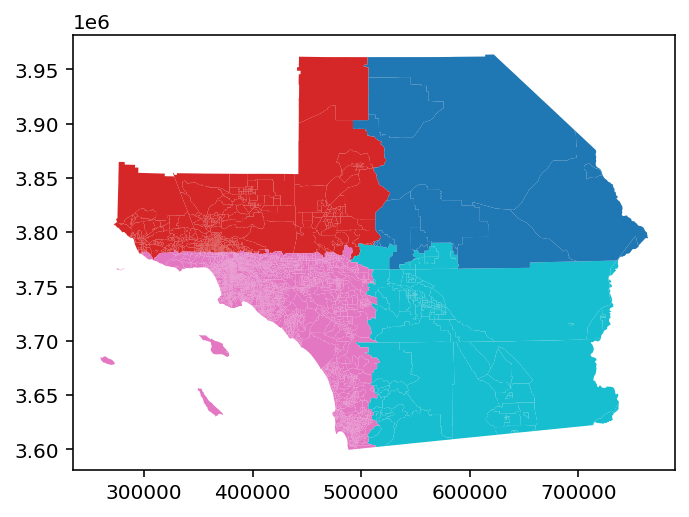

In [64]:
df['quad'] = quad
df.plot(column="quad", categorical=True)

In [65]:
blockW = libpysal.weights.block_weights(df["quad"])

/Users/knaaptime/anaconda3/envs/pysal-workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  warnings.warn(message)


In [66]:
blockW.n

4580

In [67]:
blockW.pct_nonzero

65.53761369920483

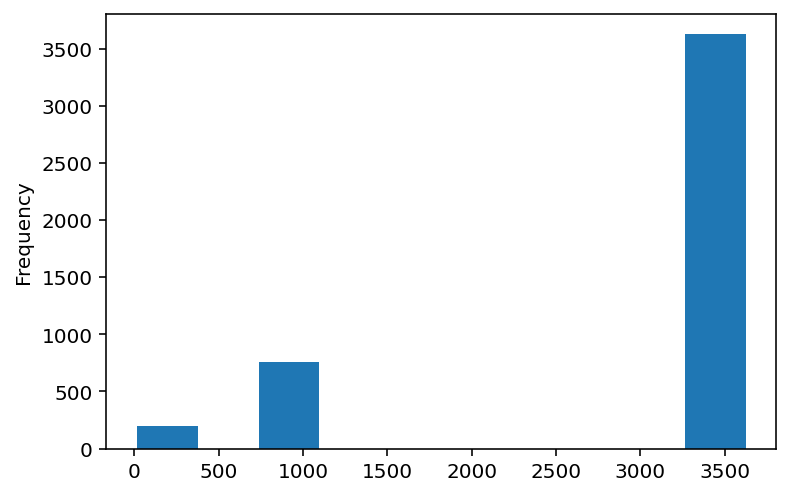

In [68]:
pandas.Series(blockW.cardinalities).plot.hist()

In [69]:
df.groupby(by='quad').count()

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,...,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry
quad,,,,,,,,,,,,,,,,,,,,,
1,15,15,15,15,15,15,15,0,0,0,...,15,15,15,0,0,0,0,0,0,15
2,761,761,761,761,761,761,761,0,0,0,...,761,761,755,0,0,0,0,0,0,761
3,3625,3625,3625,3625,3625,3625,3625,0,0,0,...,3625,3625,3612,0,0,0,0,0,0,3625
4,179,179,179,179,179,179,179,0,0,0,...,179,179,179,0,0,0,0,0,0,179


In [70]:
#plot_spatial_weights(blockW, df)

<div class="alert alert-success" style="font-size:120%">
<b>Exercise</b>: <br>
    Which spatial weights structure would be more dense, tracts based on rook contiguity or Texas counties based on knn with k=4?
</div>

In [71]:
# %load solutions/

<div class="alert alert-success" style="font-size:120%">
<b>Exercise</b>: <br>
    Which tracts have fewer neighbors under rook contiguity relative to knn4?
</div>

In [72]:
# %load solutions/

<div class="alert alert-success" style="font-size:120%">
<b>Exercise</b>: <br>
    Which tracts have identicical neighbors under queen contiguity and queen rook contiguity?
</div>

In [73]:
# %load solutions/

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-
sa/4.0/"><img alt="Creative Commons License" style="border-width:0"
src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span
xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Spatial Weights</span> by <a xmlns:cc="http://creativecommons.org/ns#"
href="http://sergerey.org" property="cc:attributionName"
rel="cc:attributionURL">Serge Rey</a> is licensed under a <a
rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative
Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.